In [1]:
#http://www.vision.caltech.edu/Image_Datasets/Caltech101/
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import os
import sys
import shutil

In [4]:
#big_images
count = 0
for d in os.listdir('big_images'):
    for f in os.listdir('big_images/' + d):
        shutil.move('big_images/' + d + '/'+f,'caltech/image' + str(count) + '.jpg')
        count+=1

In [6]:
import imageio
allims = []
for f in os.listdir('caltech'):
    allims.append(imageio.imread('caltech/' + f))

In [7]:
shapes = [im.shape for im in allims]
from collections import Counter
cnt = Counter(shapes)
print(cnt)
print(cnt.most_common(10))

Counter({(225, 300, 3): 306, (300, 300, 3): 197, (128, 192, 3): 168, (197, 300): 125, (300, 225, 3): 109, (200, 300, 3): 79, (199, 300, 3): 47, (300, 200, 3): 45, (240, 300, 3): 44, (223, 300, 3): 41, (197, 300, 3): 40, (224, 300, 3): 40, (202, 300, 3): 39, (198, 300, 3): 38, (201, 300, 3): 38, (214, 300, 3): 37, (226, 300, 3): 36, (180, 300, 3): 34, (220, 300, 3): 33, (234, 300, 3): 32, (203, 300, 3): 32, (206, 300, 3): 32, (192, 128, 3): 32, (215, 300, 3): 31, (194, 300, 3): 30, (300, 297, 3): 30, (221, 300, 3): 30, (196, 300, 3): 29, (222, 300, 3): 29, (207, 300, 3): 29, (300, 298, 3): 28, (210, 300, 3): 28, (216, 300, 3): 28, (261, 300, 3): 28, (241, 300, 3): 27, (218, 300, 3): 27, (260, 300, 3): 27, (295, 300, 3): 27, (287, 300, 3): 26, (271, 300, 3): 26, (197, 261, 3): 26, (204, 300, 3): 26, (195, 300, 3): 25, (208, 300, 3): 25, (285, 300, 3): 25, (192, 300, 3): 25, (255, 300, 3): 25, (233, 300, 3): 25, (196, 261, 3): 25, (254, 300, 3): 25, (227, 300, 3): 24, (300, 210, 3): 24, (

In [10]:
def squarify(im):
    smallside = min(im.shape[:2])
    start1 = int(np.floor((im.shape[0]-smallside)/2))
    start2 = int(np.floor((im.shape[1]-smallside)/2))
    return im[start1:start1+smallside,start2:start2+smallside]

In [12]:
print(squarify(np.random.random([300,305,3])).shape)

(300, 300, 3)


In [13]:
squares = [squarify(im) for im in allims]

In [14]:
print(len(squares))

9111


In [17]:
print(np.mean([im.shape[0] for im in squares]))

226.80276588738886


In [18]:
from skimage.transform import resize
resized = [resize(im,(200,200),anti_aliasing=True) for im in squares]

/Users/nameerhirschkind/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


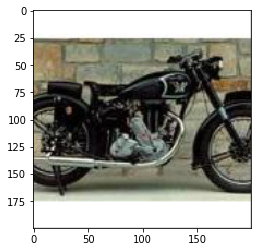

In [21]:
from matplotlib import pyplot as plt
plt.imshow(resized[1090])

In [53]:
resized = list(filter(lambda x: x.shape!=(200,200),resized))

In [56]:
for i,im in enumerate(resized):
    pickle.dump(im,open('resized/image' + str(i) + '.pkl','wb'))

In [44]:
#ok, let's put together a model for these images
from tensorflow.keras import layers

def conv(num_filters,size,stride,inp):
    return layers.Conv2D(num_filters,[size,size],strides=stride,padding='same',use_bias=True)(inp)
def conv_block(num_filters,size,stride,inp):
    c = conv(num_filters,size,stride,inp)
    p1 = layers.LeakyReLU()(c)
    return layers.BatchNormalization()(p1)

#start with 200x200x3 images
inp = tf.keras.Input(shape=[200,200,3])

c1r1 = conv_block(3,10,1,inp)
c2r1 = conv(3,10,1,c1r1)
l1 = layers.add([c2r1,inp])
l1ac = layers.LeakyReLU()(l1)
l1bn = layers.BatchNormalization()(l1ac)
l1mp = layers.MaxPool2D(2,padding='same')(l1bn) #100x100x3

l2 = conv_block(48,8,2,l1mp) #50x50x48

c1r2 = conv_block(48,5,1,l2)
c2r2 = conv(48,10,1,c1r2)
l2 = layers.add([c2r2,l2])
l2ac = layers.LeakyReLU()(l2)
l2bn = layers.BatchNormalization()(l2ac)
l2mp = layers.MaxPool2D(2,padding='same')(l2bn) #25x25x24

flat1 = layers.Flatten()(l2mp)
embed = layers.Dense(625,activation='tanh')(flat1)

encoder = tf.keras.Model(inputs=inp,outputs=embed)

unflat = layers.Reshape([25,25,1])(embed)

def deconv(filters,size,strides,inp):
    return layers.Conv2DTranspose(filters,[size,size],padding='same',strides=strides,use_bias=True)(inp)
def deconvBlockLR(filters,size,strides,inp):
    l1 = deconv(filters,size,strides,inp)
    l2 = layers.LeakyReLU()(l1)
    l3 = layers.BatchNormalization()(l2)
    return l3
def deconvBlockTH(filters,size,strides,inp):
    l1 = deconv(filters,size,strides,inp)
    l2 = layers.Activation('tanh')(l1)
    return l2


deconv1 = deconvBlockLR(12,3,2,unflat) #50x50
deconv2 = deconvBlockLR(24,5,2,deconv1) #100x100
deconv3 = deconvBlockTH(3,8,2,deconv2)#200x200

together = tf.keras.Model(inputs=inp,outputs=deconv3)

together.compile(loss='mse',optimizer='adam',metrics=[])
together.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 200, 200, 3)  903         input_13[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_46 (LeakyReLU)      (None, 200, 200, 3)  0           conv2d_47[0][0]                  
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 200, 200, 3)  12          leaky_re_lu_46[0][0]             
____________________________________________________________________________________________

In [54]:
together.fit(np.array(resized),np.array(resized),epochs=1,verbose=1,batch_size=16)

KeyboardInterrupt: 

1
